<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

In [2]:
from collections import defaultdict
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from utilities_functions import *

In [4]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              BaggingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [5]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write an index with the content included in that section (see 'feature engineering' section if needed)
- Please write paragraphs before and after each cell that presents a new inisght. Do not assumer they are too obvious
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)


## Set-up

In [6]:
file_path ="../dataset/dynamic_dataset.csv"
df = pd.read_csv(file_path)

In [4]:
df.head()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  Memory_PrivateDirty  \
0            31053             2448               14044                23472   
1           107787            21976               11852                74548   
2            86584            18460               12284                59992   
3            41248              924               10328                36280   
4            38621             5080               12392                27388   

   Memory_SharedClean  Memory_PrivateClean  Memory_SwapPssDirty  \
0               74824                 2452                    0   
1               69052                23152                    0   
2               91548                19376                    0   
3               55768                  928                    0   
4               71048                 5088                    0   

   Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  ...  Logcat_error  \
0             8919              4786             4132  ...          1635   
1            25341             20965             4375  ...          1816   
2            24500             21378             3121  ...          2244   
3            10082              7281             2800  ...           974   
4             9077              5750             3326  ...           936   

   Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  Process_total  \
0            2351          3285            1551         11221            193   
1             826          1544            2045          8457            189   
2            3406          1565            2819         10780            195   
3            4134          3138            1556         11739            191   
4            2298          3752            1992         10488            188   

                                                Hash    Category    Family  \
0  f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...  Trojan_SMS    opfake   
1  556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...  Trojan_SMS    opfake   
2  398322f94b5bfa2a9e7b3756a4cf409764595003280c48...  Trojan_SMS  fakeinst   
3  4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...  Trojan_SMS  fakeinst   
4  6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...  Trojan_SMS  fakeinst   

   reboot  
0  before  
1  before  
2  before  
3  before  
4  before  

[5 rows x 145 columns]

In [350]:
#Dataset size
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 53439 rows and 145 columns.


In [351]:
#Column Names
print("\nColumn Names:")
print(df.columns.tolist())


Column Names:
['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelCount', 'Memory_DeathRecipients', 'Memory_OpenSSLSockets', 'Memory_WebViews', 'API_Process_android.os.Process_start', 'API_Process_android.app.ActivityManager_killBackgroundProcesses', 'API_Process_android.os.Process_killProcess', 'API_Command_java.lang.Runtime_exec', 'API_Command_java.lang.ProcessBuilder_start', 'API_JavaNativeInterface_java.lang.Runtime_loadLibrary', 'API_JavaNativeInterface_java.lang.Runtime_load', 'API_WebView_android.webkit.WebView_loadUrl', 'API_WebView_android.webkit.WebView_loadData', 'API_WebView_android.webkit.WebView_loadDataWithBaseUR

In [352]:
#Data Types
print("\nData Types:")
print(df.dtypes.value_counts())


Data Types:
int64     141
object      4
Name: count, dtype: int64


In [353]:
#General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53439 entries, 0 to 53438
Columns: 145 entries, Memory_PssTotal to reboot
dtypes: int64(141), object(4)
memory usage: 59.1+ MB


### Notebook-level constants

In [17]:
ONLY_NUMERICAL_COLUMNS = df.select_dtypes(include='number')
RANDOM_STATE = 99

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them

| Category | Feature Name | Description |
|----------|-------------|-------------|
| Memory | Memory_PssTotal | Total proportional set size (PSS) memory used by the process. |
| Memory | Memory_PssClean | Clean PSS memory that is not modified since it was loaded. |
| Memory | Memory_SharedDirty | Memory shared between processes that has been modified. |
| Memory | Memory_PrivateDirty | Memory allocated to the process that has been modified. |
| Memory | Memory_SharedClean | Shared memory that has not been modified. |
| Memory | Memory_PrivateClean | Private memory that has not been modified. |
| Memory | Memory_SwapPssDirty | Amount of swapped dirty memory. |
| Memory | Memory_HeapSize | Total heap memory allocated for the process. |
| Memory | Memory_HeapAlloc | Portion of heap memory currently in use. |
| Memory | Memory_HeapFree | Available heap memory not currently in use. |
| Memory | Memory_Views | Number of view objects in the process. |
| Memory | Memory_ViewRootImpl | Number of ViewRootImpl instances in the process. |
| Memory | Memory_AppContexts | Number of application context instances. |
| Memory | Memory_Activities | Number of active activities. |
| Memory | Memory_Assets | Number of asset allocations in memory. |
| Memory | Memory_AssetManagers | Number of AssetManager instances. |
| Memory | Memory_LocalBinders | Number of local binder objects. |
| Memory | Memory_ProxyBinders | Number of proxy binder objects. |
| Memory | Memory_ParcelMemory | Memory allocated for IPC parcels. |
| Memory | Memory_ParcelCount | Number of IPC parcels in use. |
| Memory | Memory_DeathRecipients | Number of registered death recipient callbacks. |
| Memory | Memory_OpenSSLSockets | Number of OpenSSL socket connections. |
| API | API_Process_android.os.Process_start | Starts a new process. |
| API | API_Process_android.app.ActivityManager_killBackgroundProcesses | Terminates background processes. |
| API | API_Process_android.os.Process_killProcess | Kills a specific process by its PID. |
| API | API_Command_java.lang.Runtime_exec | Executes a system command. |
| API | API_Command_java.lang.ProcessBuilder_start | Starts a new process using ProcessBuilder. |
| API | API_JavaNativeInterface_java.lang.Runtime_loadLibrary | Loads a native library. |
| API | API_JavaNativeInterface_java.lang.Runtime_load | Loads a dynamic library. |
| API | API_WebView_android.webkit.WebView_loadUrl | Loads a URL in WebView. |
| API | API_WebView_android.webkit.WebView_loadData | Loads raw HTML data in WebView. |
| API | API_WebView_android.webkit.WebView_loadDataWithBaseURL | Loads HTML data with a base URL. |
| API | API_WebView_android.webkit.WebView_addJavascriptInterface | Adds a JavaScript interface to WebView. |
| API | API_WebView_android.webkit.WebView_evaluateJavascript | Evaluates JavaScript in WebView. |
| API | API_WebView_android.webkit.WebView_postUrl | Posts data to a URL via WebView. |
| API | API_WebView_android.webkit.WebView_postWebMessage | Sends a web message via WebView. |
| API | API_WebView_android.webkit.WebView_savePassword | Saves login credentials in WebView. |
| API | API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword | Sets HTTP authentication credentials. |
| API | API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword | Retrieves saved HTTP authentication credentials. |
| API | API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled | Enables WebView debugging. |
| API | API_FileIO_libcore.io.IoBridge_open | Opens a file or socket. |
| API | API_FileIO_android.content.ContextWrapper_openFileInput | Opens a private file for reading. |
| API | API_FileIO_android.content.ContextWrapper_openFileOutput | Opens a private file for writing. |
| API | API_FileIO_android.content.ContextWrapper_deleteFile | Deletes a private file. |
| API | API_Database_android.content.ContextWrapper_openOrCreateDatabase | Opens or creates a database. |
| API | API_Database_android.content.ContextWrapper_databaseList | Lists databases in the app. |
| API | API_Database_android.content.ContextWrapper_deleteDatabase | Deletes a database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_execSQL | Executes a raw SQL query. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase | Deletes an SQLite database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_getPath | Retrieves the database file path. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_insert | Inserts a new record. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow | Inserts a record, throwing an exception on failure. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict | Inserts a record with conflict resolution. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_openDatabase | Opens an existing database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase | Opens or creates an SQLite database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_query | Executes a query on the database. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory | Executes a query using a factory. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_rawQuery | Runs a raw SQL query. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory | Runs a raw query with a factory. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_update | Updates a database record. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict | Updates a record with conflict resolution. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_compileStatement | Compiles an SQL statement. |
| API | API_Database_android.database.sqlite.SQLiteDatabase_create | Creates a new database. |
| API | API_IPC_android.content.ContextWrapper_sendBroadcast | Sends a broadcast message. |
| API | API_IPC_android.content.ContextWrapper_sendStickyBroadcast | Sends a sticky broadcast message. |
| API | API_IPC_android.content.ContextWrapper_startActivity | Starts an activity. |
| API | API_IPC_android.content.ContextWrapper_startService | Starts a service. |
| API | API_IPC_android.content.ContextWrapper_stopService | Stops a service. |
| API | API_IPC_android.content.ContextWrapper_registerReceiver | Registers a broadcast receiver. |
| API | API_Binder_android.app.ContextImpl_registerReceiver | Registers a receiver in the app context. |
| API | API_Binder_android.app.ActivityThread_handleReceiver | Handles broadcast receivers in ActivityThread. |
| API | API_Binder_android.app.Activity_startActivity | Starts an activity from another component. |
| API | API_Crypto_javax.crypto.spec.SecretKeySpec_$init | Initializes a secret key specification. |
| API | API_Crypto_javax.crypto.Cipher_doFinal | Performs encryption or decryption. |
| API | API_Crypto-Hash_java.security.MessageDigest_digest | Computes a cryptographic hash. |
| API | API_Crypto-Hash_java.security.MessageDigest_update | Updates a message digest with input data. |
| API | API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId | Retrieves the device ID. |
| API | API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId | Retrieves the subscriber ID. |
| API | API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number | Retrieves the device’s phone number. |
| API | API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator | Retrieves the network operator name. |
| API | API_DeviceInfo_android.net.wifi.WifiInfo_getMacAddress | Retrieves the device’s MAC address. |
| API | API_DeviceInfo_android.net.wifi.WifiInfo_getIpAddress | Retrieves the device’s IP address. |
| Network | Network_TotalReceivedBytes | Total bytes received over the network. |
| Network | Network_TotalReceivedPackets | Total network packets received. |
| Network | Network_TotalTransmittedBytes | Total bytes transmitted over the network. |
| Network | Network_TotalTransmittedPackets | Total network packets transmitted. |
| Battery | Battery_wakelock | Tracks wake lock usage. |
| Logcat | Logcat_verbose | Captures verbose log messages. |
| Logcat | Logcat_debug | Captures debug log messages. |
| Logcat | Logcat_info | Captures info log messages. |
| Logcat | Logcat_warning | Captures warning log messages. |
| Logcat | Logcat_error | Captures error log messages. |
| Process | Process_total | Tracks total active processes. |


### CONSTANTS SECTIONS

In [355]:
feature_dict = {
    "Memory_PssTotal": "Total proportional set size (PSS) memory used by the process.",
    "Memory_PssClean": "Clean PSS memory that is not modified since it was loaded.",
    "Memory_SharedDirty": "Memory shared between processes that has been modified.",
    "Memory_PrivateDirty": "Memory allocated to the process that has been modified.",
    "Memory_SharedClean": "Shared memory that has not been modified.",
    "Memory_PrivateClean": "Private memory that has not been modified.",
    "Memory_SwapPssDirty": "Amount of swapped dirty memory.",
    "Memory_HeapSize": "Total heap memory allocated for the process.",
    "Memory_HeapAlloc": "Portion of heap memory currently in use.",
    "Memory_HeapFree": "Available heap memory not currently in use.",
    "Memory_Views": "Number of view objects in the process.",
    "Memory_ViewRootImpl": "Number of ViewRootImpl instances in the process.",
    "Memory_AppContexts": "Number of application context instances.",
    "Memory_Activities": "Number of active activities.",
    "Memory_Assets": "Number of asset allocations in memory.",
    "Memory_AssetManagers": "Number of AssetManager instances.",
    "Memory_LocalBinders": "Number of local binder objects.",
    "Memory_ProxyBinders": "Number of proxy binder objects.",
    "Memory_ParcelMemory": "Memory allocated for IPC parcels.",
    "Memory_ParcelCount": "Number of IPC parcels in use.",
    "Memory_DeathRecipients": "Number of registered death recipient callbacks.",
    "Memory_OpenSSLSockets": "Number of OpenSSL socket connections.",
    "API_Process_android.os.Process_start": "Starts a new process.",
    "API_Process_android.app.ActivityManager_killBackgroundProcesses": "Terminates background processes.",
    "API_Process_android.os.Process_killProcess": "Kills a specific process by its PID.",
    "API_Command_java.lang.Runtime_exec": "Executes a system command.",
    "API_Command_java.lang.ProcessBuilder_start": "Starts a new process using ProcessBuilder.",
    "API_JavaNativeInterface_java.lang.Runtime_loadLibrary": "Loads a native library.",
    "API_JavaNativeInterface_java.lang.Runtime_load": "Loads a dynamic library.",
    "API_WebView_android.webkit.WebView_loadUrl": "Loads a URL in WebView.",
    "API_WebView_android.webkit.WebView_loadData": "Loads raw HTML data in WebView.",
    "API_WebView_android.webkit.WebView_loadDataWithBaseURL": "Loads HTML data with a base URL.",
    "API_WebView_android.webkit.WebView_addJavascriptInterface": "Adds a JavaScript interface to WebView.",
    "API_WebView_android.webkit.WebView_evaluateJavascript": "Evaluates JavaScript in WebView.",
    "API_WebView_android.webkit.WebView_postUrl": "Posts data to a URL via WebView.",
    "API_WebView_android.webkit.WebView_postWebMessage": "Sends a web message via WebView.",
    "API_WebView_android.webkit.WebView_savePassword": "Saves login credentials in WebView.",
    "API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword": "Sets HTTP authentication credentials.",
    "API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword": "Retrieves saved HTTP authentication credentials.",
    "API_WebView_android.webkit.WebView_setWebContentsDebuggingEnabled": "Enables WebView debugging.",
    "API_FileIO_libcore.io.IoBridge_open": "Opens a file or socket.",
    "API_FileIO_android.content.ContextWrapper_openFileInput": "Opens a private file for reading.",
    "API_FileIO_android.content.ContextWrapper_openFileOutput": "Opens a private file for writing.",
    "API_FileIO_android.content.ContextWrapper_deleteFile": "Deletes a private file.",
    "API_Database_android.content.ContextWrapper_openOrCreateDatabase": "Opens or creates a database.",
    "API_Database_android.content.ContextWrapper_databaseList": "Lists databases in the app.",
    "API_Database_android.content.ContextWrapper_deleteDatabase": "Deletes a database.",
    "API_Database_android.database.sqlite.SQLiteDatabase_execSQL": "Executes a raw SQL query.",
    "API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase": "Deletes an SQLite database.",
    "API_Database_android.database.sqlite.SQLiteDatabase_getPath": "Retrieves the database file path.",
    "API_Database_android.database.sqlite.SQLiteDatabase_insert": "Inserts a new record.",
    "API_Database_android.database.sqlite.SQLiteDatabase_insertOrThrow": "Inserts a record, throwing an exception on failure.",
    "API_Database_android.database.sqlite.SQLiteDatabase_insertWithOnConflict": "Inserts a record with conflict resolution.",
    "API_Database_android.database.sqlite.SQLiteDatabase_openDatabase": "Opens an existing database.",
    "API_Database_android.database.sqlite.SQLiteDatabase_openOrCreateDatabase": "Opens or creates an SQLite database.",
    "API_Database_android.database.sqlite.SQLiteDatabase_query": "Executes a query on the database.",
    "API_Database_android.database.sqlite.SQLiteDatabase_queryWithFactory": "Executes a query using a factory.",
    "API_Database_android.database.sqlite.SQLiteDatabase_rawQuery": "Runs a raw SQL query.",
    "API_Database_android.database.sqlite.SQLiteDatabase_rawQueryWithFactory": "Runs a raw query with a factory.",
    "API_Database_android.database.sqlite.SQLiteDatabase_update": "Updates a database record.",
    "API_Database_android.database.sqlite.SQLiteDatabase_updateWithOnConflict": "Updates a record with conflict resolution.",
    "API_Database_android.database.sqlite.SQLiteDatabase_compileStatement": "Compiles an SQL statement.",
    "API_Database_android.database.sqlite.SQLiteDatabase_create": "Creates a new database.",
    "API_IPC_android.content.ContextWrapper_sendBroadcast": "Sends a broadcast message.",
    "API_IPC_android.content.ContextWrapper_sendStickyBroadcast": "Sends a sticky broadcast message.",
    "API_IPC_android.content.ContextWrapper_startActivity": "Starts an activity.",
    "API_IPC_android.content.ContextWrapper_startService": "Starts a service.",
    "API_IPC_android.content.ContextWrapper_stopService": "Stops a service.",
    "API_IPC_android.content.ContextWrapper_registerReceiver": "Registers a broadcast receiver.",
    "API_Binder_android.app.ContextImpl_registerReceiver": "Registers a receiver in the app context.",
    "API_Binder_android.app.ActivityThread_handleReceiver": "Handles broadcast receivers in ActivityThread.",
    "API_Binder_android.app.Activity_startActivity": "Starts an activity from another component.",
    "API_Crypto_javax.crypto.spec.SecretKeySpec_$init": "Initializes a secret key specification.",
    "API_Crypto_javax.crypto.Cipher_doFinal": "Performs encryption or decryption.",
    "API_Crypto-Hash_java.security.MessageDigest_digest": "Computes a cryptographic hash.",
    "API_Crypto-Hash_java.security.MessageDigest_update": "Updates a message digest with input data.",
    "API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId": "Retrieves the device ID.",
    "API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId": "Retrieves the subscriber ID.",
    "API_DeviceInfo_android.telephony.TelephonyManager_getLine1Number": "Retrieves the device’s phone number.",
    "API_DeviceInfo_android.telephony.TelephonyManager_getNetworkOperator": "Retrieves the network operator name.",
    "API_DeviceInfo_android.net.wifi.WifiInfo_getMacAddress": "Retrieves the device’s MAC address.",
    "API_DeviceInfo_android.net.wifi.WifiInfo_getIpAddress": "Retrieves the device’s IP address.",
    "Network_TotalReceivedBytes": "Total bytes received over the network.",
    "Network_TotalReceivedPackets": "Total network packets received.",
    "Network_TotalTransmittedBytes": "Total bytes transmitted over the network.",
    "Network_TotalTransmittedPackets": "Total network packets transmitted.",
    "Battery_wakelock": "Tracks wake lock usage.",
    "Logcat_verbose": "Captures verbose log messages.",
    "Logcat_debug": "Captures debug log messages.",
    "Logcat_info": "Captures info log messages.",
    "Logcat_warning": "Captures warning log messages.",
    "Logcat_error": "Captures error log messages.",
    "Process_total": "Tracks total active processes."
}

# 1. EDA

In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

## Data Type Distribution

In [356]:
# Get the data type distribution
dtype_counts = df.dtypes.value_counts()
dtype_counts

int64     141
object      4
Name: count, dtype: int64

We can see that most columns are numerical. Lets gets to see which are the variables that are of type object.

In [357]:
df_onlyCols = df.select_dtypes(include=["object"]).columns
df_onlyCols

Index(['Hash', 'Category', 'Family', 'reboot'], dtype='object')

## Summary Statistics Overview

## Histograms


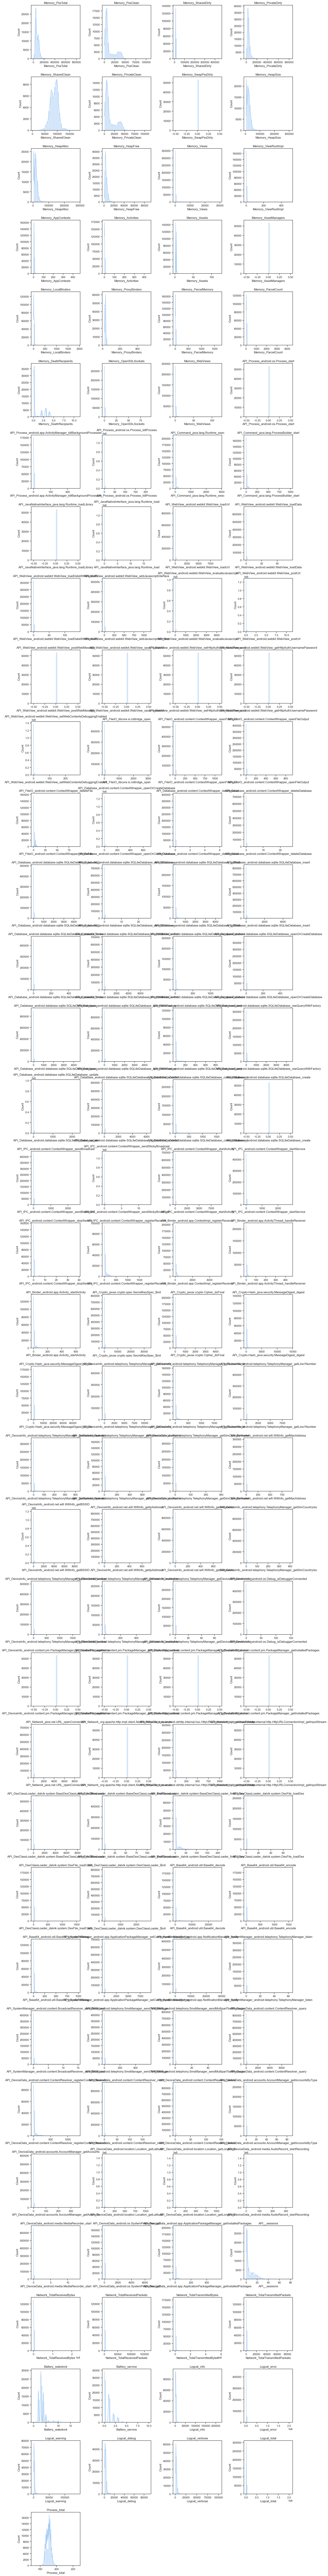

In [358]:
# Select only numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

We can see most distributions tend to be right-skewed and only a small portion follows a normal distribution. This right-skewness will be dealt in feature-engineering.

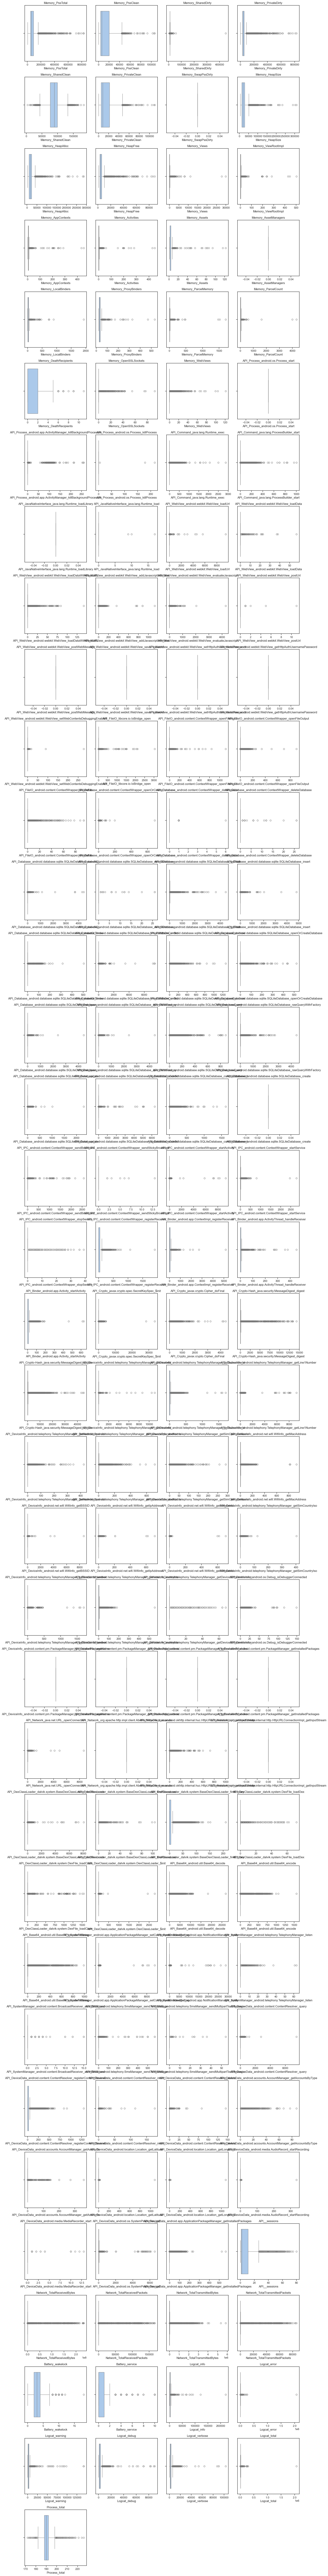

In [359]:
# Select only numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot boxplots
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])  # Boxplot for each feature
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Numerical Features

Seemed to be grouped by prefixes: Memory, Network, Battery, Logcat, Process y API.

According to dataset authors to capture how various malware families and categories behave at runtime, the analysis relies on six distinct sets of features obtained after executing each sample within a controlled emulated environment. These feature groups offer a comprehensive view of the malware's dynamic activity.

This categories appear before the first _ in every feature label and are defined as:


"Memory: Memory features define activities performed by malware by utilizing memory.

API: Application Programming Interface (API) features delineate the communication between two applications.

Network: Network features describe the data transmitted and received between other devices in the network. It indicates foreground and background network usage.

Battery: Battery features describe the access to battery wakelock and services by malware.

Logcat: Logcat features write log messages corresponding to a function performed by malware.

Process: Process features count the interaction of malware with total number of processes."



In [360]:
numeric_cols = df.select_dtypes(include='number').columns

# Grouping based on the first prefix before "_"
prefix_groups = defaultdict(list)

for col in numeric_cols:
    prefix = col.split("_")[0]  # Get the first word before the underscore
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n {prefix} ({len(columns)} features):")
    for col in columns:
        print(f"  - {col}")


 Memory (23 features):
  - Memory_PssTotal
  - Memory_PssClean
  - Memory_SharedDirty
  - Memory_PrivateDirty
  - Memory_SharedClean
  - Memory_PrivateClean
  - Memory_SwapPssDirty
  - Memory_HeapSize
  - Memory_HeapAlloc
  - Memory_HeapFree
  - Memory_Views
  - Memory_ViewRootImpl
  - Memory_AppContexts
  - Memory_Activities
  - Memory_Assets
  - Memory_AssetManagers
  - Memory_LocalBinders
  - Memory_ProxyBinders
  - Memory_ParcelMemory
  - Memory_ParcelCount
  - Memory_DeathRecipients
  - Memory_OpenSSLSockets
  - Memory_WebViews

 API (105 features):
  - API_Process_android.os.Process_start
  - API_Process_android.app.ActivityManager_killBackgroundProcesses
  - API_Process_android.os.Process_killProcess
  - API_Command_java.lang.Runtime_exec
  - API_Command_java.lang.ProcessBuilder_start
  - API_JavaNativeInterface_java.lang.Runtime_loadLibrary
  - API_JavaNativeInterface_java.lang.Runtime_load
  - API_WebView_android.webkit.WebView_loadUrl
  - API_WebView_android.webkit.WebView_l

## Categorical Features

In [361]:
#Statistical summary for categorical features
df.describe(include=["object", "category", "bool"])

Hash  Category  Family  \
count                                               53439     53439   53439   
unique                                              33426        14    3078   
top     da9f3ac7df2f0cddf8b7cc190567f0943626d545eb25bc...  Riskware  smsreg   
freq                                                    5     14053    8112   

        reboot  
count    53439  
unique       2  
top     before  
freq     28380

In [362]:
print(df[['Hash', 'Category', 'Family']].head())

                                                Hash    Category    Family
0  f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...  Trojan_SMS    opfake
1  556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...  Trojan_SMS    opfake
2  398322f94b5bfa2a9e7b3756a4cf409764595003280c48...  Trojan_SMS  fakeinst
3  4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...  Trojan_SMS  fakeinst
4  6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...  Trojan_SMS  fakeinst


Hash: unique identifier that represents each malware sample. <<<>>>THIS IS PROBABLY WRONG<<<>>>

Category: general classification of the malware sample based on its behavior.

Family: more fine-grained grouping of malware based on its codebase or origin

For hash, it will first be checked if the same malware before and after reboot contains the same hash value.

In [363]:
# Count how many times each hash appears in 'before' and 'after'
hash_reboot_counts = df.groupby(['Hash', 'reboot']).size().unstack(fill_value=0)

# Hashes in both with exactly one in each
hashes_with_one_each = hash_reboot_counts[
    (hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1)
].index

# Hashes in both but with extra rows
hashes_in_both_but_not_clean = hash_reboot_counts[
    (hash_reboot_counts['before'] > 0) &
    (hash_reboot_counts['after'] > 0) &
    ~((hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1))
].index

# Total unique hashes
total_unique_hashes = df['Hash'].nunique()

# Hashes in only one reboot condition
hashes_in_one_condition = hash_reboot_counts[
    (hash_reboot_counts['before'] == 0) | (hash_reboot_counts['after'] == 0)
]

# Only once in one reboot condition
only_once_in_one = hashes_in_one_condition[
    (hashes_in_one_condition['before'] == 1) | (hashes_in_one_condition['after'] == 1)
]

# More than once in one reboot condition
more_than_once_in_one = hashes_in_one_condition[
    ((hashes_in_one_condition['before'] > 1) & (hashes_in_one_condition['after'] == 0)) |
    ((hashes_in_one_condition['after'] > 1) & (hashes_in_one_condition['before'] == 0))
]

# Split those into counts
more_than_once_in_before = more_than_once_in_one[more_than_once_in_one['before'] > 1]
more_than_once_in_after = more_than_once_in_one[more_than_once_in_one['after'] > 1]

# --- PRINT RESULTS ---
print(f"Hashes with EXACTLY one row in BOTH before and after: {len(hashes_with_one_each)}")
print(f"Hashes in BOTH, BUT with extra rows: {len(hashes_in_both_but_not_clean)}")

print(f"\nHashes in ONLY ONE reboot condition:")
print(f"• Appearing ONLY ONCE: {len(only_once_in_one)}")
print(f"• Appearing MORE THAN ONCE: {len(more_than_once_in_one)}")
print(f"   - More than once in BEFORE: {len(more_than_once_in_before)}")
print(f"   - More than once in AFTER: {len(more_than_once_in_after)}")

print(f"\nTotal breakdown:")
print(f"• In BOTH (any): {len(hashes_with_one_each) + len(hashes_in_both_but_not_clean)}")
print(f"• In ONLY ONE reboot: {len(hashes_in_one_condition)}")
print(f"• TOTAL unique hashes: {total_unique_hashes}")


Hashes with EXACTLY one row in BOTH before and after: 19169
Hashes in BOTH, BUT with extra rows: 158

Hashes in ONLY ONE reboot condition:
• Appearing ONLY ONCE: 13695
• Appearing MORE THAN ONCE: 404
   - More than once in BEFORE: 404
   - More than once in AFTER: 0

Total breakdown:
• In BOTH (any): 19327
• In ONLY ONE reboot: 14099
• TOTAL unique hashes: 33426


A total of 19,169 hashes appear exactly once in both before and after conditions. These are highly reliable for paired  comparisons, ideal for understanding how reboot affects malware behavior.


There are 158 hashes that appear in both reboot states but not exactly once in each. These extra instances may come from inconsistencies in data capture like multiple logs for the same sample and should be checked.

A significant portion of samples appear only in one reboot condition. This is consistent with limitations described in the original dataset paper, where some malware samples failed to execute after the reboot. However, what is curious is that some still have been logged more than once.


In [364]:
df = df.drop(columns=['Hash'])
'''
The Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.
It serves as an identifier for each malware sample. Including this column in modeling
would not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are
sensitive to high-cardinality categorical features.
 <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the 
  argumentation in a text cell not in this type of comments. <<<>>>
'''

'\nThe Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.\nIt serves as an identifier for each malware sample. Including this column in modeling\nwould not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are\nsensitive to high-cardinality categorical features.\n <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the \n  argumentation in a text cell not in this type of comments. <<<>>>\n'

This research will be using both Category and Family as the target variables for classification.

## Reboot Analysis

In [365]:
print(df["reboot"].value_counts())

reboot
before    28380
after     25059
Name: count, dtype: int64


The imbalance observed in the dataset, with 28,380 samples collected before reboot and only 25,059 after reboot, is explained by limitations found during the dynamic analysis. The authors of the dataset note that "there was no entry point in some Android malware samples and some Android malware samples stopped abruptly." This means that certain malware applications either failed to launch or terminated unexpectedly during execution, preventing the collection of dynamic behavior data, particularly after the reboot phase.

Additionally, the study highlights another critical limitation: "the dynamic analysis is performed in an emulator. Some malware samples are able to detect the emulated environment and are not executed." This behavior reflects common anti-analysis techniques used by sophisticated malware, which can detect when they are running in a sandbox or emulator and intentionally suspend their malicious actions.




<<<>>>THIS ANALYSIS IS SUPER GOOD (you can delete this comment)<<<>>>

The displayed features are the top 10  most affected by reboot showing a clear reboot-sensitive behavior.

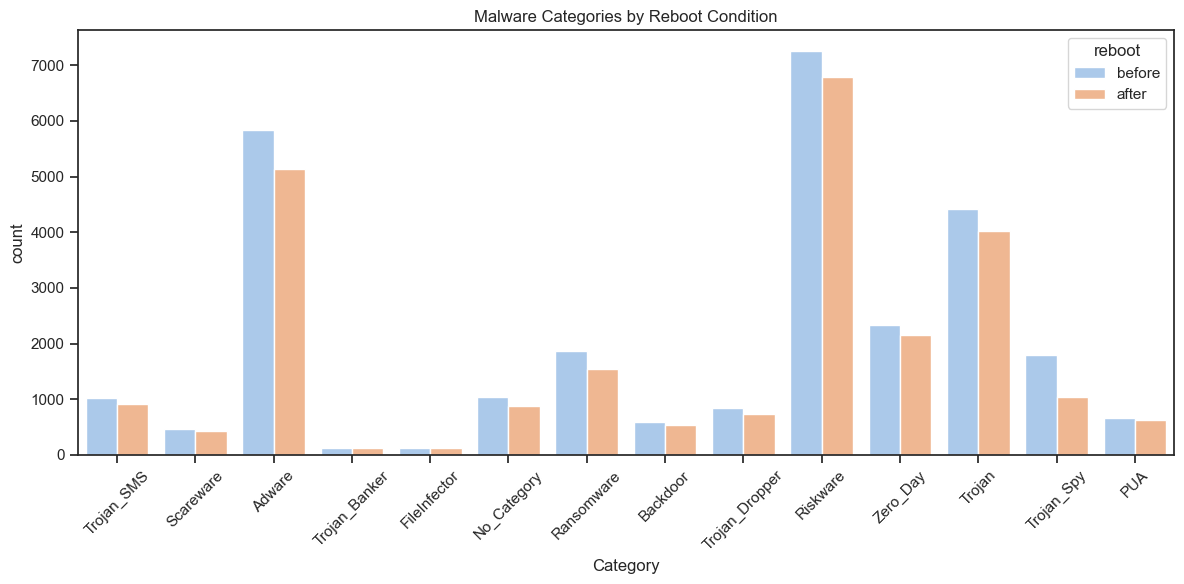

In [366]:
#Category distribution across reboot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category', hue='reboot')
plt.title("Malware Categories by Reboot Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


To identify which numeric features are most influenced by the reboot condition, the dataset will be grouped by the reboot variable, separating entries collected before and after the device reboot. Within each group, the mean of every numeric feature will be computed, allowing for the comparison of average behavior across both states.

A new column labeled 'diff' was then added, representing the difference between the mean values after and before the reboot for each feature. A positive value indicates that the feature increased after reboot, while a negative value shows it decreased.

In [367]:
reboot_means = df.groupby('reboot').mean(numeric_only=True).T
reboot_means['diff'] = reboot_means['after'] - reboot_means['before']
reboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)

reboot_means_sorted.head(10)

reboot                                        after        before  \
Network_TotalReceivedBytes             1.064726e+06  1.010731e+06   
Memory_SharedClean                     9.197948e+04  8.445062e+04   
Network_TotalTransmittedBytes          3.212833e+04  3.068837e+04   
Memory_HeapSize                        2.246240e+04  2.211749e+04   
Memory_HeapAlloc                       1.769606e+04  1.740553e+04   
Memory_PrivateClean                    1.438378e+04  1.425724e+04   
Memory_PrivateDirty                    4.766433e+04  4.760709e+04   
Memory_HeapFree                        4.765345e+03  4.710971e+03   
API_Base64_android.util.Base64_decode  2.266345e+02  1.784744e+02   
Network_TotalReceivedPackets           8.214127e+02  7.823693e+02   

reboot                                         diff  
Network_TotalReceivedBytes             53995.332815  
Memory_SharedClean                      7528.856824  
Network_TotalTransmittedBytes           1439.967512  
Memory_HeapSize                          344.902678  
Memory_HeapAlloc                         290.528862  
Memory_PrivateClean                      126.536769  
Memory_PrivateDirty                       57.248200  
Memory_HeapFree                           54.373837  
API_Base64_android.util.Base64_decode     48.160124  
Network_TotalReceivedPackets              39.043392

The results reveal that several features show clear shifts after reboot. Specially, network-related features such as Network_TotalReceivedBytes and Network_TotalTransmittedBytes demonstrate significant increases, suggesting that some malware types intensify data transmission once the device has rebooted. Memory features like Memory_SharedClean, Memory_HeapSize, and Memory_HeapAlloc also show increased values after reboot, indicating greater memory use or altered memory management after reboot.
This shows that the reboot condition plays an important role in runtime behavior and should be treated as an important factor in exploratory analysis and modeling.

## Missing Values

In [368]:
#AGREGAR LO DE NO_CATEGORY @Jon

In [369]:
#Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False))


Missing Values:
Memory_PssTotal                                                              0
Memory_PssClean                                                              0
API_DeviceInfo_android.content.pm.PackageManager_getInstallerPackageName     0
API_DeviceInfo_android.content.pm.PackageManager_getInstalledApplications    0
API_DeviceInfo_android.content.pm.PackageManager_getInstalledModules         0
                                                                            ..
API_Database_android.database.sqlite.SQLiteDatabase_execSQL                  0
API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase           0
API_Database_android.database.sqlite.SQLiteDatabase_getPath                  0
API_Database_android.database.sqlite.SQLiteDatabase_insert                   0
reboot                                                                       0
Length: 144, dtype: int64


In [370]:
print("Any missing values in the DataFrame:", df.isnull().values.any())

Any missing values in the DataFrame: False


Although the dataset does not contain null values, this does not necessarily mean it is free of missing information. Placeholders are commonly used in place of missing, uncollected, or undetected values. These placeholders may take the form of strings like "<unknown>", "unknown", "UNK", or values such as "0", "-1", or "none" Despite they are not technically null they still represent incomplete data.

This hidden labels can have implications for data quality and model performance. If not properly identified and handled, these placeholder values can introduce noise or skew statistical summaries.

For textual placeholders:

In [371]:
placeholders = ["<unknown>", "unknown", "UNKNOWN", "UNK", "?", "NA", "N/A", "-1", "0", "none", "null", "NULL"]

for value in placeholders:
    print(f"\nOccurrences of '{value}':")
    print((df == value).sum().sort_values(ascending=False))


Occurrences of '<unknown>':
Family                                                                              1817
Memory_PssTotal                                                                        0
API_Network_com.android.okhttp.internal.huc.HttpURLConnectionImpl_getInputStream       0
API_DeviceInfo_android.content.pm.PackageManager_getInstallerPackageName               0
API_DeviceInfo_android.content.pm.PackageManager_getInstalledApplications              0
                                                                                    ... 
API_Database_android.database.sqlite.SQLiteDatabase_execSQL                            0
API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase                     0
API_Database_android.database.sqlite.SQLiteDatabase_getPath                            0
API_Database_android.database.sqlite.SQLiteDatabase_insert                             0
reboot                                                                           

<<<>>> I WOULD SUGGEST YOU DONT HARDCODE THE PLACEHOLDERS BUT ACTUALLY LOOK FOR THE DISTRIBUTION OF VALUES IN THE CATEGORICAL VARIABLES THAT MAY REPRESENT THIS. WE RISK SKIPPING SOME PLACEHOLDER THAT WAS NOT ANTICIPATED <<<>>>

In [372]:
placeholders = ["<unknown>", "unknown", "UNK", "?", "NA", "N/A", "none", "null", "NULL"]

for value in placeholders:
    counts = (df == value).sum()

    filtered = counts[counts > 0].sort_values(ascending=False)

    if not filtered.empty:
        print(f"Occurrences of '{value}':")
        print(filtered)


Occurrences of '<unknown>':
Family    1817
dtype: int64


Family feature contains placeholder for missing values: <<xx>unknown>

For numeric placeholders:

In [373]:
numeric_placeholders = [-1, 9999, 0, 1]

for value in numeric_placeholders:
    counts = (df.select_dtypes(include="number") == value).sum()
    filtered = counts[counts > 0].sort_values(ascending=False)
    if not filtered.empty:
        print(f"\nNumeric placeholder occurrences: {value}")
        print(filtered)


Numeric placeholder occurrences: 9999
Logcat_total                     8
Memory_HeapFree                  4
Memory_HeapSize                  2
Network_TotalTransmittedBytes    2
Network_TotalReceivedBytes       1
Logcat_debug                     1
Logcat_verbose                   1
dtype: int64

Numeric placeholder occurrences: 0
API_DeviceInfo_android.content.pm.PackageManager_getInstalledPackages        53439
API_Database_android.database.sqlite.SQLiteDatabase_create                   53439
API_DeviceInfo_android.content.pm.PackageManager_getInstallerPackageName     53439
API_DeviceInfo_android.content.pm.PackageManager_getInstalledApplications    53439
API_DeviceInfo_android.content.pm.PackageManager_getInstalledModules         53439
                                                                             ...  
API__sessions                                                                  727
Memory_PssClean                                                                560
Bat

A large number of features contain a value of 0 in every row, indicating that they offer no variability across the dataset. This may suggest that these features were never triggered during execution or were not properly captured due to limitations in the process. Regardless of the reason, such features provide no useful information for distinguishing between different malware categories and therefore do not contribute to predictive modeling.

Check for infinity or -inifity placeholders:

In [374]:
has_inf = df.isin([np.inf, -np.inf]).any().any()
print("Contains inf:", has_inf)

Contains inf: False


In [375]:
#Count duplicated values
df.duplicated().sum()

np.int64(0)

## DEALING WITH CLASS IMABLANCE

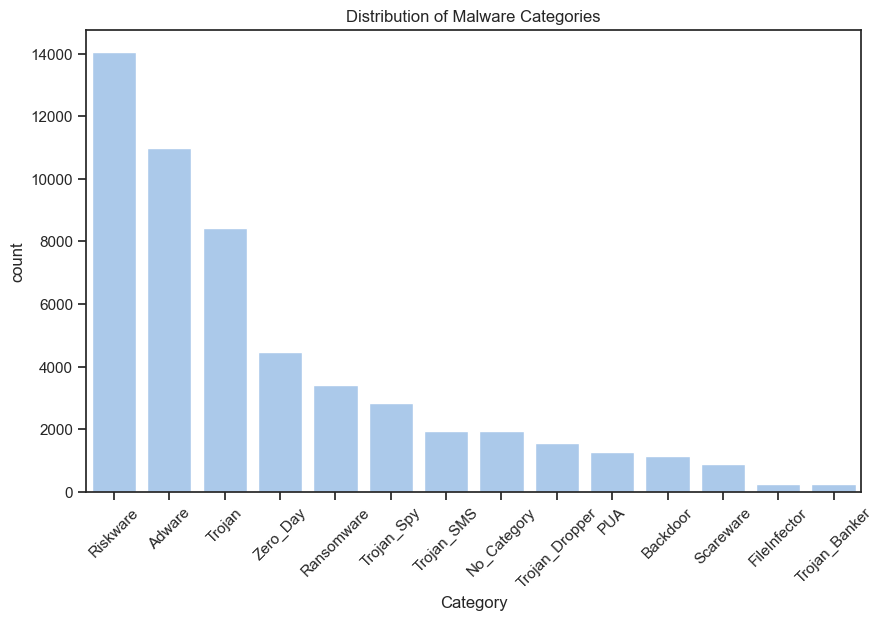

In [376]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="Category", order=df["Category"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Malware Categories")
plt.show()

The malware category distribution in the dataset is highly imbalanced, with a few classes (like Riskware, Adware, and Trojan) dominating the majority of samples.

This can lead to a situation where a classifier becomes biased toward the majority classes, achieving high overall accuracy but failing to correctly identify underrepresented malware types such as Trojan_Banker or FileInfector.

To address this, stratified sampling should be applied when splitting the dataset to preserve class proportions. During model training, techniques such as class weighting, SMOTE (Synthetic Minority Over-sampling Technique), ADASYN (Adaptive Synthetic Sampling), or under-sampling to balance the classes should be considered.

## Family

In [377]:
#How many categories each family belongs to
df.groupby("Family")["Category"].nunique().sort_values(ascending=False)

Family
<unknown>                                     13
SINGLETON:ba60c1384287f563319fe5b312ec283b     1
SINGLETON:c6f985d70c1d48ddbbaec022307cea30     1
SINGLETON:c7148e2031c52963b90c1467e63f648e     1
SINGLETON:c72d206bab845abf3df0000f8b1340b1     1
                                              ..
SINGLETON:67b02f528af4280994dec96feafcc4ed     1
SINGLETON:67d9596432fbca73f4002839321b0618     1
SINGLETON:67e4fcd0d451c14289ab23ebc5539e67     1
SINGLETON:67efeb3118b4df3f543bc9a0ad3d4185     1
zypush                                         1
Name: Category, Length: 3078, dtype: int64

Almost every family is either unknown or unique


In [378]:
# <<<Error: NameError: name 'family_to_category' is not defined>>>
# multi_cat_families = family_to_category[family_to_category > 1]
# print(f"Number of families mapping to multiple categories: {len(multi_cat_families)}")
# print(multi_cat_families)

There is only one Family that maps to multiple categories, and is the placeholder unknown.

The following code displays how many samples with unknown family labels belong to each malware category.

In [379]:
df[df["Family"] == "<unknown>"]["Category"].value_counts()

Category
Riskware          597
Trojan            418
Zero_Day          176
Ransomware        137
Trojan_Spy        130
Trojan_SMS         81
No_Category        66
Trojan_Dropper     56
Backdoor           52
PUA                45
Scareware          37
FileInfector       17
Trojan_Banker       5
Name: count, dtype: int64

In [380]:
# Step 1: Count unique families per category
family_amount = df.groupby("Category")["Family"].nunique()

# Step 2: Total number of instances per category
total_per_category = df["Category"].value_counts()

# Step 3: Count how many of those are <unknown> per category
unknown_amount = df[df["Family"] == "<unknown>"]["Category"].value_counts()

# Step 4: Combine all stats into a summary table
summary_df = pd.DataFrame({
    "Family_amount": family_amount,
    "Total_category": total_per_category,
    "Unknown_amount": unknown_amount
}).fillna(0).astype({"Unknown_amount": int})

# Step 5: Calculate percentage of unknowns per category
summary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)

# Reorder columns for readability
summary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]

# Display the summary
print(summary_df)

                Family_amount  Total_category  Unknown_amount  %_Unknown
Category                                                                
Adware                     43           10980               0       0.00
Backdoor                   11            1137              52       4.57
FileInfector                5             248              17       6.85
No_Category               335            1932              66       3.42
PUA                         9            1290              45       3.49
Ransomware                  8            3411             137       4.02
Riskware                   19           14053             597       4.25
Scareware                   4             886              37       4.18
Trojan                     38            8437             418       4.95
Trojan_Banker              11             241               5       2.07
Trojan_Dropper             10            1570              56       3.57
Trojan_SMS                 10            1939      

In [381]:
unknown_count = (df["Family"] == "<unknown>").sum()
print(f"Number of rows with Family == '<unknown>': {unknown_count}")


Number of rows with Family == '<unknown>': 1817


Based on the analysis of family distribution across categories:

The Adware category stands out with zero instances labeled as <unknown> and a balanced distribution across 43 families. This makes it a strong candidate for modeling.

In contrast, Zero_Day and No_Category The categories Zero_Day and No_Category exhibit extremely high family dispersion, with 2576 and 335 unique families. These values are significantly higher than all other categories, which generally have fewer than 50 families each.


This suggests they function more as placeholder labels. In particular, Zero_Day likely serves as a catch-all label for unknown or uncategorized threats, making it ambiguous. In cybersecurity, this term is refered to a new unknown vulnerability, not yet classified in terms of malware behavior, this is why samples are varied. They do not seem to represent a consistent type. On the other hand, No_Category explicitly denotes a lack of category. So, including these instances would only bring noise to the training process, preventing the model from learning meaningful patterns.
Therefore, they are excluded from the final dataset to preserve the quality and consistency of the classification task.


Additionally, categories like FileInfector show a high percentage of <unknown> families (6.85%) despite having a small total count, raising concerns about label quality. Most other categories maintain a relatively stable level of unknowns (around 3–5%), indicating that the presence of <unknown> is manageable.

# FEATURE ANALYSIS

INDEX OF CONTENT:
- Feature transformation
- Feature engineering
- Feature selection


### QUESTIONS
- How does feature hashing relate here?
- How can PCA be useful here? Should colinarity analysis be done before or after PCA?
- For right-skewness may this be useful?
- Is too much variance equally as bad as too low?

## FEATURE TRANSFORMATION

- Binning
- Log transformation 
- Interaction terms

### QUESTIONS
- We do have to do log-transformation before data-scaling, right? Or is that consider a feature scaling by itself?

As we had anticipated before, many of the features' values distribution seem to have a heavy presence of right-skweness. Log-transfomration is the perfect solution for this

In [ ]:
# <<<>>> TO BE DONE <<<>>>
# 1) Find number-based way to find right-skewness
# 2) Apply log-transformation to those features with right-skewness

## FEATURE ENGINEERING
- Domain-specific features

NOTE: This requires further understanding of the concepts around our problem's context. This will be deferred for a second iteration.

## FEATURE SELECTION
- Analyze correlation and low-variances
- Remove low-predictive power variables


### > QUESTIONS
- Why is VIF being infinte in the study of multicolinearity?

#### 1.1) Eliminating low-variances features
We will start off feature selection by analyzing the variables that have low variances. Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset.

We will first analyze the distribution of the variances. We will not plot variances that are outliers in the distribution.

In [7]:
numeric_cols = df.copy().select_dtypes(include='number')

variances = numeric_cols.var()

# Compute the first (Q1) and third quartiles (Q3)
Q1 = variances.quantile(0.25)
Q3 = variances.quantile(0.75)

IQR = Q3 - Q1

postiveOutliers = Q3 + 3 * IQR
negativeOutliers = Q1 - 3 * IQR

priorLength = len(variances)
cols_to_keep = variances[(variances <= postiveOutliers) & (variances >= negativeOutliers)].index
newLength = len(cols_to_keep)
print(f"Removed {priorLength - newLength} features with outliers of variance")

temp_df = numeric_cols[cols_to_keep]

Removed 25 features with outliers of variance


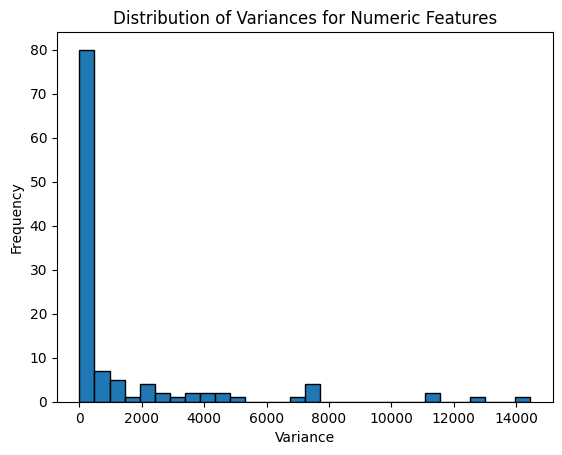

In [8]:
plt.hist(temp_df.var(), bins=30, edgecolor='black')
plt.title('Distribution of Variances for Numeric Features')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()


Lets dig deeper into the values around 0 so that we can select a better threshold for low-variance elimination

In [9]:
df.shape

(53439, 145)

In [10]:
cols_to_keep = variances[(variances < 100)].index
temp_df = numeric_cols[cols_to_keep]

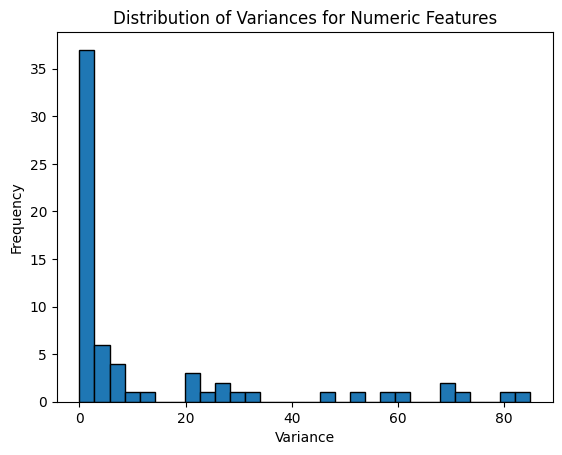

In [11]:
basic_distribution_plot(temp_df.var(), 'Distribution of Variances for Numeric Features', 'Variance', 'Frequency', bins=30)

There seems to be a lot (almost 1/5) of features with very low variance. Our current selection for the variance threshold is going to be 1 unit of variance. 

In [12]:
MIN_SIGMA_THRESHOLD = 1

In [13]:
originalCols = df.shape[1]
# Getting the variances of all features 
for col in list(df.select_dtypes(include='number').columns):
  colVariance = df[col].var()
  if colVariance < MIN_SIGMA_THRESHOLD:
    print(f">> Deleting '{col}' because of low variance: [{colVariance}]")
    df.drop(columns=[col], inplace=True)

newCols = df.shape[1]
print(f">> Deleted {originalCols - newCols} features with low variance")
    

>> Deleting 'Memory_SwapPssDirty' because of low variance: [0.0]
>> Deleting 'Memory_AssetManagers' because of low variance: [0.0]
>> Deleting 'API_Process_android.os.Process_start' because of low variance: [0.0]
>> Deleting 'API_JavaNativeInterface_java.lang.Runtime_loadLibrary' because of low variance: [0.0]
>> Deleting 'API_JavaNativeInterface_java.lang.Runtime_load' because of low variance: [0.008794785509359962]
>> Deleting 'API_WebView_android.webkit.WebView_loadData' because of low variance: [0.28444821721030483]
>> Deleting 'API_WebView_android.webkit.WebView_postUrl' because of low variance: [0.0031433763997375953]
>> Deleting 'API_WebView_android.webkit.WebView_postWebMessage' because of low variance: [0.0]
>> Deleting 'API_WebView_android.webkit.WebView_savePassword' because of low variance: [0.0]
>> Deleting 'API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword' because of low variance: [0.0]
>> Deleting 'API_WebView_android.webkit.WebView_getHttpAuthUsernamePassw

As a quick side check we can also see that all columns have not constant values (as expected). This is critical for the analysis of multicolinearity via VIF.

In [14]:
(df.nunique() < 1).sum()

np.int64(0)

#### 1.2) Eliminating highly correlated feature
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

[np.float64(-0.4583048977425148), np.float64(1.0)]

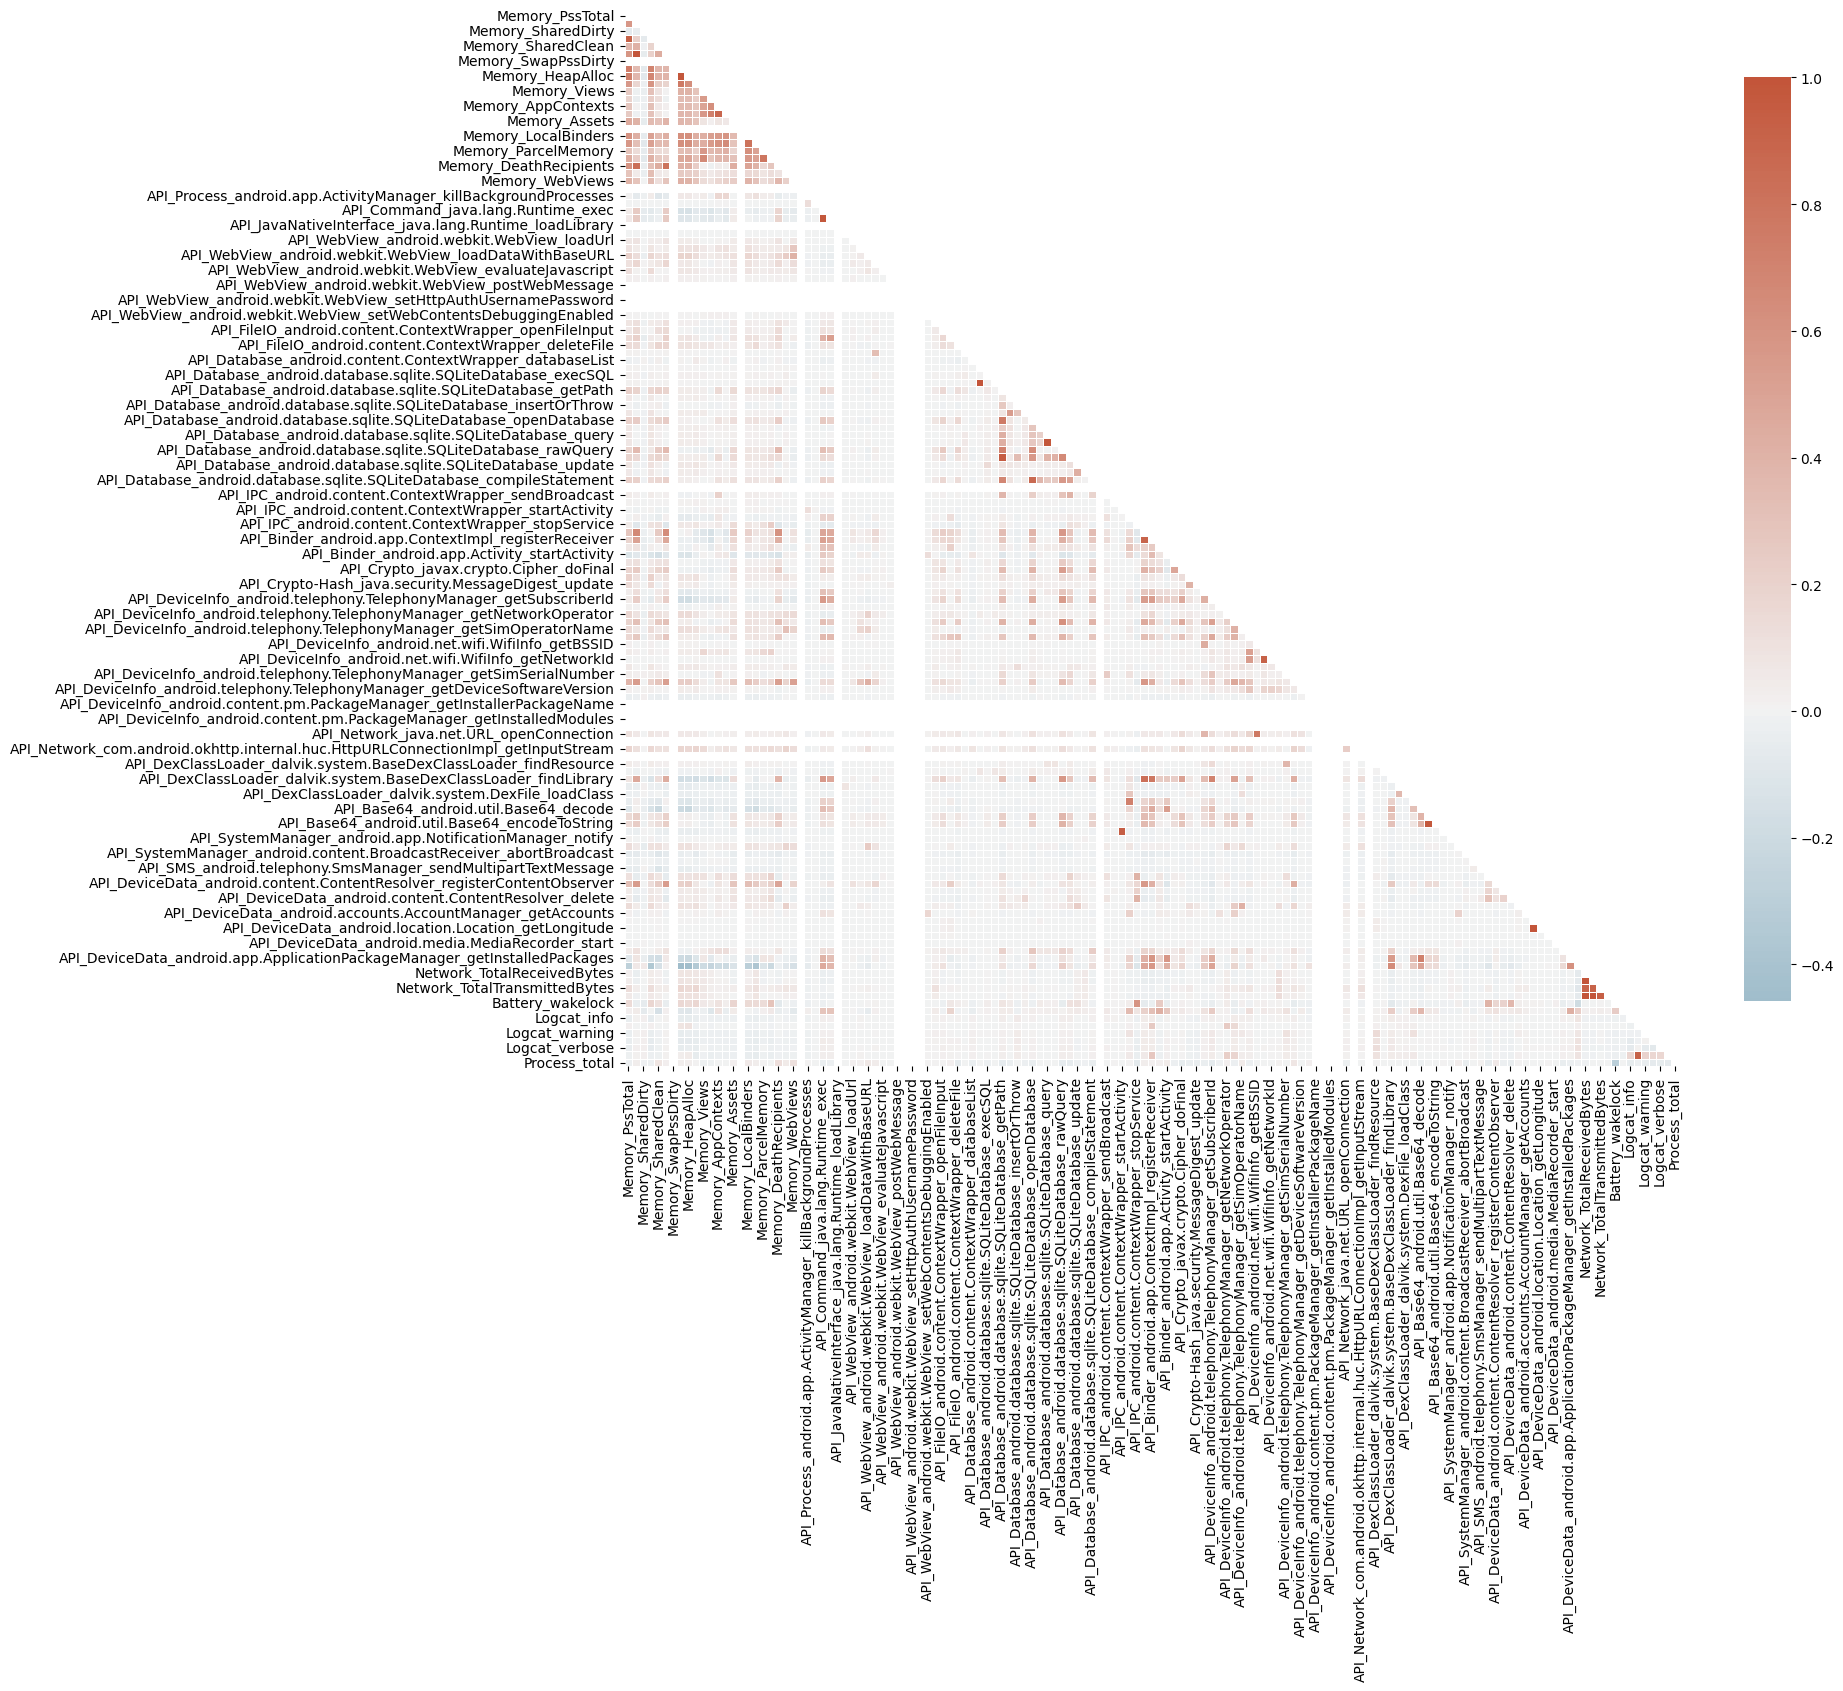

In [15]:
compute_correlation_matrix((17, 15), ONLY_NUMERICAL_COLUMNS)

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.

Well, thats a lot to digest! Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.

In [399]:
vif_data = pd.DataFrame()
vif_data["Feature"] = ONLY_NUMERICAL_COLUMNS.columns
vif_data["VIF"] = [variance_inflation_factor(ONLY_NUMERICAL_COLUMNS.values, i) for i in range(ONLY_NUMERICAL_COLUMNS.shape[1])]
vif_data.sort_values(by="VIF", ascending=False)

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Feature       VIF
113                                       Logcat_total       inf
112                                     Logcat_verbose       inf
111                                       Logcat_debug       inf
110                                     Logcat_warning       inf
109                                       Logcat_error       inf
..                                                 ...       ...
22          API_Process_android.os.Process_killProcess  1.019618
79   API_DexClassLoader_dalvik.system.BaseDexClassL...  1.018653
88   API_SystemManager_android.app.NotificationMana...  1.007875
90   API_SMS_android.telephony.SmsManager_sendTextM...  1.006828
99   API_DeviceData_android.media.AudioRecord_start...  1.001076

[115 rows x 2 columns]

In [402]:
vif_data[vif_data["VIF"] >= 5].shape

(52, 2)

In [408]:
# Lets check in the heatmap if we have any multicolinearity
corr_matrix = ONLY_NUMERICAL_COLUMNS.corr()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [420]:
# Find highly correlated feature pairs
high_corr_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature_1", "level_1": "Feature_2", 0: "Correlation"})
)

# Filter correlations above 0.65 or below -0.65
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > 0.7]
high_corr_pairs

Feature_1  \
2                                       Memory_PssTotal   
5                                       Memory_PssTotal   
6                                       Memory_PssTotal   
117                                     Memory_PssClean   
130                                     Memory_PssClean   
341                                 Memory_PrivateDirty   
572                                 Memory_PrivateClean   
669                                     Memory_HeapSize   
670                                     Memory_HeapSize   
1096                                Memory_ViewRootImpl   
1199                                 Memory_AppContexts   
1505                                Memory_LocalBinders   
1704                                Memory_ParcelMemory   
2369                 API_Command_java.lang.Runtime_exec   
3477  API_Database_android.database.sqlite.SQLiteDat...   
3481  API_Database_android.database.sqlite.SQLiteDat...   
3482  API_Database_android.database.sqlite.SQLiteDat...   
3787  API_Database_android.database.sqlite.SQLiteDat...   
3927  API_Database_android.database.sqlite.SQLiteDat...   
4511  API_IPC_android.content.ContextWrapper_startAc...   
4570  API_IPC_android.content.ContextWrapper_startSe...   
4664  API_IPC_android.content.ContextWrapper_registe...   
4690  API_IPC_android.content.ContextWrapper_registe...   
4750  API_Binder_android.app.ContextImpl_registerRec...   
5481  API_DeviceInfo_android.net.wifi.WifiInfo_getBSSID   
5520  API_DeviceInfo_android.net.wifi.WifiInfo_getIp...   
6106              API_Base64_android.util.Base64_decode   
6120              API_Base64_android.util.Base64_encode   
6402  API_DeviceData_android.location.Location_getLa...   
6489                         Network_TotalReceivedBytes   
6490                         Network_TotalReceivedBytes   
6491                         Network_TotalReceivedBytes   
6500                       Network_TotalReceivedPackets   
6501                       Network_TotalReceivedPackets   
6510                      Network_TotalTransmittedBytes   
6543                                       Logcat_error   

                                              Feature_2  Correlation  
2                                   Memory_PrivateDirty     0.909073  
5                                       Memory_HeapSize     0.741273  
6                                      Memory_HeapAlloc     0.729111  
117                                 Memory_PrivateClean     0.991000  
130                              Memory_DeathRecipients     0.821429  
341                                     Memory_HeapSize     0.703282  
572                              Memory_DeathRecipients     0.810914  
669                                    Memory_HeapAlloc     0.983376  
670                                     Memory_HeapFree     0.759632  
1096                                  Memory_Activities     0.721426  
1199                                  Memory_Activities     0.883952  
1505                                Memory_ProxyBinders     0.804443  
1704                                 Memory_ParcelCount     0.779317  
2369         API_Command_java.lang.ProcessBuilder_start     0.974978  
3477  API_Database_android.database.sqlite.SQLiteDat...     0.758908  
3481  API_Database_android.database.sqlite.SQLiteDat...     0.708075  
3482  API_Database_android.database.sqlite.SQLiteDat...     0.958108  
3787  API_Database_android.database.sqlite.SQLiteDat...     0.863267  
3927  API_Database_android.database.sqlite.SQLiteDat...     0.987015  
4511  API_SystemManager_android.app.ApplicationPacka...     0.937394  
4570  API_DexClassLoader_dalvik.system.DexClassLoade...     0.721511  
4664  API_Binder_android.app.ContextImpl_registerRec...     0.898059  
4690  API_DexClassLoader_dalvik.system.BaseDexClassL...     0.834645  
4750  API_DexClassLoader_dalvik.system.BaseDexClassL...     0.776902  
5481            API_Network_java.net.URL_openConnection     0.768625  
5520  API_Device

There seems to be some clear signs of correlation. However, for the first iteration we are going to be conservative and not remove them (for now). Note however, that some of the correlations show seem to make a lot of sense (e.g: Network_TotalReceivedBytes, Network_TotalTransmittedBytes)

#### 2.1) Eliminating low-predictive power variabes


As we have analyzed before 'Hash' is an approximation to a unique identifiers. This adds singificant noise to the model. Lets remove it 

In [7]:
df.drop(columns=["Hash"], inplace=True)

In [7]:
#df.drop(columns=["reboot"], inplace=True)  <<<>>> MAY GET DELETED, IF ANALYSIS INDICATES THIS IS MEANINGFUL

### Questions
- What other encoders could be useful?

# MODEL SELECTION

### QUESTION
- How can statistical measurement help on the split?
### TBD (to be done)
- 

## DATA SPLITTING

80% for training, 20% for hold-out sets (evenly distributed)

In [8]:
df.columns

Index(['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty',
       'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean',
       'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc',
       'Memory_HeapFree',
       ...
       'Logcat_info', 'Logcat_error', 'Logcat_warning', 'Logcat_debug',
       'Logcat_verbose', 'Logcat_total', 'Process_total', 'Category', 'Family',
       'reboot'],
      dtype='object', length=144)

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

In [8]:
X_category, y_category = get_X_y(df, "Category", ["Family"])

Before we continue with the split, lets advance some for the time we get to the encoding process. 
We are gonna check how many categorical variables are present in each matrix

In [9]:
X_category.select_dtypes(include=["object"])

reboot
0      before
1      before
2      before
3      before
4      before
...       ...
53434  before
53435  before
53436  before
53437  before
53438  before

[53439 rows x 1 columns]

In [11]:
y_category

0        Trojan_SMS
1        Trojan_SMS
2        Trojan_SMS
3        Trojan_SMS
4        Trojan_SMS
            ...    
53434           PUA
53435           PUA
53436           PUA
53437           PUA
53438           PUA
Name: Category, Length: 53439, dtype: object

Also object!
Lets get back to the splitting!

In [10]:
X_category_train, X_category_val, X_category_test, y_category_train, y_category_val, y_category_test = get_split_data(X_category, y_category, train_size=0.8, validation_size=0.1, test_size=0.1, random_state=99)

X_category_train.shape, X_category_val.shape, X_category_test.shape, y_category_train.shape, y_category_val.shape, y_category_test.shape


((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

### Encoding

#### Encoding the X matrices (one-hot encoder)

Lets fit the X encoder for the object column (reboot)

In [11]:
X_category_train_encoded, X_category_val_encoded, X_category_test_encoded = get_X_sets_encoded(X_category_train, X_category_val, X_category_test)

Lets visualize the results of the encoding...

In [22]:
X_category_train_encoded

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
48143            35115             2936               12944   
10388            71418            11352                8960   
11029           120450            30872               10704   
36609            42669             4156               12544   
26413            65679             3256               10792   
...                ...              ...                 ...   
42697            35571              208               11060   
36008            52445             5196               12452   
46265            37220             3464               12612   
23587           113947            39996               10852   
29313            79501             5476               10600   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
48143                25560               83552                 3072   
10388                46700               84844                11468   
11029                71532              132144                31660   
36609                29872               91184                 4172   
26413                52684              101276                 6004   
...                    ...                 ...                  ...   
42697                32352               56960                  212   
36008                36008               98696                 7208   
46265                27708               82884                 3488   
23587                60764               99972                41624   
29313                66556               94636                 5580   

       Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  Memory_Views  ...  \
48143             9086              5558             3527            13  ...   
10388            15178             11581             3596            27  ...   
11029            37109             30762             6346            17  ...   
36609            13283             10668             2614            10  ...   
26413            32054             24837             7216           360  ...   
...                ...               ...              ...           ...  ...   
42697             9027              5661             3365             0  ...   
36008            17994             15059             2934            39  ...   
46265            10049              7028             3020             8  ...   
23587            43932             31028            12903            36  ...   
29313            27634             20688             6945           142  ...   

       Network_TotalTransmittedPackets  Battery_wakelock  Logcat_info  \
48143                                0                 3         4372   
10388                                0                 2          693   
11029                              123                 2         2422   
36609                               86                 5         2323   
26413                               27                 3         2271   
...                                ...               ...          ...   
42697                                0                 3         1801   
36008                              129                 3          113   
46265                                0                 5         3582   
23587                               37                 5          926   
29313                               40                 8          820   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
48143          2820            1369          1567            4737   
10388            99            2863          1702            2804   
11029          2959             925            98            3416   
36609           149             783          1954            2908   
26413          7564             626          1826             139   
...             ...             ...           ...             ...   
42697          1512            1660          1308             404   
36008  

In [23]:
X_category_val_encoded

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
18288            89260            35468               10708   
40648            48666            12528               10656   
8718             46730             5972               12100   
5961             52168             5372               12236   
32688            92303            25632               10584   
...                ...              ...                 ...   
20920            56561             1940               10620   
33656           114597            13464               11176   
32607           117458            37848               10640   
8923            101636            42696               11792   
38099            51156             5052               11076   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
18288                43912              101788                37024   
40648                26508               71024                12660   
8718                 32660               93356                 6100   
5961                 33636               89756                 7224   
32688                58220               89048                26916   
...                    ...                 ...                  ...   
20920                44556               95240                 4684   
33656                88344               83848                17952   
32607                62936              112004                44524   
8923                 45016               99032                44444   
38099                37104               89148                 7908   

       Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  Memory_Views  ...  \
18288            13438             10484             2953            28  ...   
40648             7571              4444             3126             8  ...   
8718             21473             17870             3602            29  ...   
5961             17434             14267             3166            34  ...   
32688            31904             24735             7168           138  ...   
...                ...               ...              ...           ...  ...   
20920            19531             16995             2535           118  ...   
33656            33963             26513             7449           162  ...   
32607            43343             37854             5488           191  ...   
8923             26615             22085             4529             9  ...   
38099            19344             16648             2695            46  ...   

       Network_TotalTransmittedPackets  Battery_wakelock  Logcat_info  \
18288                              433                 4         1260   
40648                                5                 3         3730   
8718                                58                 8         1363   
5961                                77                 3         4297   
32688                               42                 2         1442   
...                                ...               ...          ...   
20920                              102                 5          705   
33656                               27                 4         2736   
32607                               39                 3         5119   
8923                               218                 4         2489   
38099                                0                 2         3312   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
18288          1890            3822          4762            3532   
40648          2898             113           970            3147   
8718            465            2332           138            1468   
5961           1748            3056          2978            1014   
32688          1665             734           110            2522   
...             ...             ...           ...             ...   
20920          1833            2840          1516            4116   
33656  

In [24]:
X_category_test_encoded

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
28550           142029             9644               10804   
43091            35900                0               11228   
8287            120639            32164               10724   
47969            32216             3552               12936   
29839            80737             2556               11012   
...                ...              ...                 ...   
53065            56160             8456               12012   
49176            40409             1268               11204   
30395            71344             4576               10624   
4491             39970             1692               10688   
2304             66112            26888               10180   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
28550               123028               67116                10220   
43091                33240               52236                    4   
8287                 79364              102076                33536   
47969                23972               66432                 3564   
29839                64316               90308                10252   
...                    ...                 ...                  ...   
53065                34720               96740                11544   
49176                35692               62172                 1272   
30395                57848              107704                 4616   
4491                 29372               88400                 3964   
2304                 26108               58108                27336   

       Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  Memory_Views  ...  \
28550            40778             30782             9995            67  ...   
43091             9026              5604             3421             0  ...   
8287             37049             29643             7405           163  ...   
47969             7897              4791             3105             0  ...   
29839            47900             36743            11156           235  ...   
...                ...               ...              ...           ...  ...   
53065            11466              8843             2622            31  ...   
49176             7921              5985             1935             0  ...   
30395            24922             19530             5391           112  ...   
4491             12228              9262             2965            28  ...   
2304              8796              6031             2764            29  ...   

       Network_TotalTransmittedPackets  Battery_wakelock  Logcat_info  \
28550                              278                 4         1854   
43091                                0                 3          753   
8287                               657                 2          115   
47969                                0                 3         2657   
29839                                0                 2          626   
...                                ...               ...          ...   
53065                               25                 6         2503   
49176                                0                 3         1529   
30395                               22                 8         3398   
4491                                 7                 6         1560   
2304                                12                 4         1070   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
28550          1162            1512          1975            2807   
43091          1673            2602          1541            3550   
8287           2370            3863          1387            1691   
47969          1561            4380          3265            1415   
29839          2142            2488           195            4399   
...             ...             ...           ...             ...   
53065          1609           10482           956            3464   
49176  

Awesome, the X matrices are all set now. Lets finally encode the target variable (which we saw in the split process is of dtype: object)

#### Encoding y matrix (labeller encoding) 

In [25]:
y_category_train

48143        Trojan
10388        Adware
11029        Adware
36609      Riskware
26413      Zero_Day
            ...    
42697    Trojan_Spy
36008      Riskware
46265        Trojan
23587      Riskware
29313        Trojan
Name: Category, Length: 42751, dtype: object

We know our models analyze the target variable in a numerical way. Lets transform this series then!

In [12]:
labeller = LabelEncoder()
labeller.fit(y_category_train)

LabelEncoder()

In [11]:
y_category_train


48143        Trojan
10388        Adware
11029        Adware
36609      Riskware
26413      Zero_Day
            ...    
42697    Trojan_Spy
36008      Riskware
46265        Trojan
23587      Riskware
29313        Trojan
Name: Category, Length: 42751, dtype: object

In [13]:
y_category_train_encoded, y_category_val_encoded, y_category_test_encoded = get_y_sets_encoded(y_category_train, y_category_val, y_category_test)

One more time, let's visualize the results

In [37]:
y_category_train_encoded, "-"*30,  y_category_val_encoded, "-"*30, y_category_test_encoded, 

(48143     8
 10388     0
 11029     0
 36609     6
 26413    13
          ..
 42697    12
 36008     6
 46265     8
 23587     6
 29313     8
 Length: 42751, dtype: int64,
 '------------------------------',
 18288    6
 40648    6
 8718     0
 5961     0
 32688    8
         ..
 20920    6
 33656    3
 32607    8
 8923     0
 38099    6
 Length: 5344, dtype: int64,
 '------------------------------',
 28550    13
 43091    12
 8287      0
 47969     8
 29839     8
          ..
 53065     4
 49176     5
 30395     8
 4491      0
 2304      0
 Length: 5344, dtype: int64)

# MODELLING

## Automatic Feature Selection
Lets briefly extend our feature selection process:

### QUESTIONS
- Can this part not be done in feature engineering?
### TBD (things to be done)
- Read more about boruta

#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses.



In [20]:
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10)

In [21]:
# Train logistic regression model with L1 penalty
model.fit(X_category_train_encoded, y_category_train_encoded)

# Get the coefficients of the trained model
coefficients = model.coef_
coefficients

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([[ 3.52001101e-07, -2.11600389e-06, -7.46306474e-06, ...,
        -5.18139806e-06, -2.31710823e-03,  1.23810477e-01],
       [-1.17434459e-05,  2.78407323e-05, -7.89300921e-05, ...,
         2.09437504e-06, -6.30204780e-03, -5.75751599e-02],
       [ 3.57333184e-06,  1.40098795e-05, -1.70825803e-04, ...,
        -3.17966742e-06, -1.19730070e-03,  5.58641116e-02],
       ...,
       [-1.76576387e-06,  1.40346416e-05,  1.10002504e-05, ...,
         8.04709849e-06, -9.54332742e-04,  2.13987456e-01],
       [ 5.27080971e-07, -4.11648832e-05, -1.71042104e-04, ...,
        -4.86982921e-06,  8.13140277e-04,  3.21642409e-01],
       [ 1.14178981e-06,  1.43946153e-05, -4.96242471e-05, ...,
        -2.17527793e-05, -3.59461063e-03,  3.38535811e-02]])

In [22]:
predictivePowerVariables = set()
for i in range(len(coefficients[0])):
      if abs(coefficients[0][i]) > 0:
            predictivePowerVariables.add(X_category_train_encoded.columns[i])
excludedVariables = set(X_category_train_encoded.columns) - predictivePowerVariables
predictivePowerVariables, "-"*30, f"Number of predictive power variables: {len(predictivePowerVariables)}", "-"*30, excludedVariables, "-"*30, f"Number of excluded variables: {len(excludedVariables)}"

({'API_Base64_android.util.Base64_decode',
  'API_Base64_android.util.Base64_encode',
  'API_Base64_android.util.Base64_encodeToString',
  'API_Binder_android.app.ActivityThread_handleReceiver',
  'API_Binder_android.app.Activity_startActivity',
  'API_Binder_android.app.ContextImpl_registerReceiver',
  'API_Command_java.lang.ProcessBuilder_start',
  'API_Command_java.lang.Runtime_exec',
  'API_Crypto-Hash_java.security.MessageDigest_digest',
  'API_Crypto-Hash_java.security.MessageDigest_update',
  'API_Crypto_javax.crypto.Cipher_doFinal',
  'API_Crypto_javax.crypto.spec.SecretKeySpec_$init',
  'API_Database_android.content.ContextWrapper_databaseList',
  'API_Database_android.content.ContextWrapper_deleteDatabase',
  'API_Database_android.content.ContextWrapper_openOrCreateDatabase',
  'API_Database_android.database.sqlite.SQLiteDatabase_compileStatement',
  'API_Database_android.database.sqlite.SQLiteDatabase_deleteDatabase',
  'API_Database_android.database.sqlite.SQLiteDatabase_ex

#### Boruta

In [23]:
# Initialize your base estimator. Here we use a RandomForestClassifier.
rf = RandomForestClassifier(
    n_estimators=100,    # You can adjust this as needed
    n_jobs=-1, # multithreading
    class_weight='balanced',
    random_state=RANDOM_STATE
)

In [24]:
boruta_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=2,
    random_state=RANDOM_STATE,
    max_iter=10
)
# Fit Boruta on your training data.
boruta_selector.fit(X_category_train_encoded.values, y_category_train_encoded.values)
selected_mask = boruta_selector.support_
selected_features = X_category_train_encoded.columns[selected_mask]
print("Selected Features:", list(selected_features))

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	142
Rejected: 	0


KeyboardInterrupt: 

In [ ]:
# TO BE DONE, function that elimiantes variables from the dataset

## Fitting the model

### TO BE ADDED 
- Multiple models as classifiers
- Family as the target variable
- Other meaningful metrics (e.g: f1)

## Random Forest 
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster

In [26]:
model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
model.fit(X_category_train_encoded, y_category_train_encoded)

RandomForestClassifier(random_state=99)

In [28]:
y_val_pred = model.predict(X_category_val_encoded)
y_test_pred = model.predict(X_category_test_encoded)
y_val_pred, y_test_pred

(array([6, 6, 0, ..., 8, 0, 0]), array([ 0, 12,  0, ...,  8,  0,  0]))

Test Accuracy: 0.8374

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1116
           1       0.84      0.74      0.79       115
           2       0.94      0.59      0.73        27
           3       0.82      0.43      0.56       189
           4       0.91      0.79      0.84       126
           5       0.81      0.88      0.84       350
           6       0.88      0.90      0.89      1364
           7       0.88      0.89      0.88        88
           8       0.84      0.91      0.87       810
           9       0.74      0.61      0.67        33
          10       0.83      0.50      0.62       167
          11       0.89      0.71      0.79       208
          12       0.90      0.88      0.89       286
          13       0.75      0.63      0.69       465

    accuracy                           0.84      5344
   macro avg       0.84      0.74      0.78      5344
weighted avg       0.84      0.84 

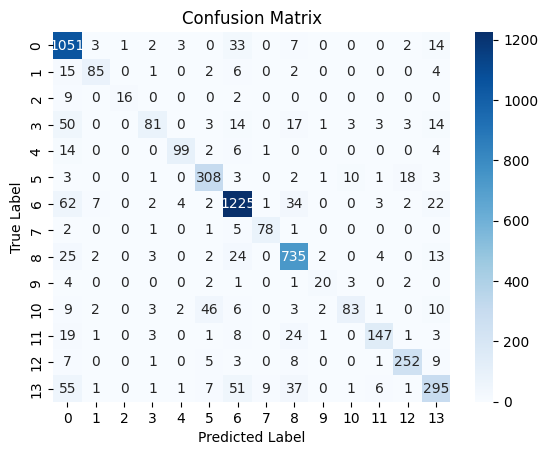

In [31]:
# Evaluation Metrics
val_accuracy = accuracy_score(y_category_test_encoded, y_test_pred)
#test_accuracy = accuracy_score(y_category_test_encoded, y_test_pred)

print(f"Test Accuracy: {val_accuracy:.4f}")
#print(f"Test Accuracy: {test_accuracy:.4f}")


# Classification Report
print("\nClassification Report:")
print(classification_report(y_category_test_encoded, y_test_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_category_test_encoded, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Testing set evaluation
# print("\nTest Set Classification Report:")
# print(classification_report(y_category_test_encoded, y_test_pred))

### Classification Scores Function
(this will eventually be moved to utilities_functions.py )

### Model assesment (validation set)

#### Hyperparameter Tuning

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear'],  
    'class_weight': ['balanced', None],  
}


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_category_train_encoded, y_category_train_encoded)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

## ADVANCED THINGS
- Cluster analysis to better understand the features
- Doing PCA for features (after correlation analysis)
- Distilled models
- DevOPs pipeline design